# Load Dataset

In [1]:
#import library
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from collections import defaultdict
import re
from collections import defaultdict, Counter

C:\Users\User\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#load dataset
df = pd.read_csv("ukraine_v2.csv")
df = df[['article_title', 'author', 'published_time', 'article_text']]
df.head()

,article_title,author,published_time,article_text
0,"NATO, US put Ukraine’s EU membership in dilemma",By Global Times,"Published: Jun 22, 2022 11:21 PM",Illustration: Chen Xian/Global TimesUkraine is...
1,Xi offers answers to questions of the times at...,By \n\n\n\n\n Yang Sheng \nYang Sheng is a chi...,"Published: Jun 23, 2022 12:07 AM",Chinese President Xi Jinping delivers a keynot...
2,Wild ambition of NATO against public’s will,By Lu Xue,"Published: Jun 23, 2022 12:23 AM",Illustration: Liu Rui/Global TimesEditor's Not...
3,Title not found,Author not found,Published time not found,Article text not found
4,Egyptian Red Sea resort Sharm el-Sheikh reels ...,By Reuters,"Published: Jun 23, 2022 04:10 PM","A picture taken on September 29, 2021 shows Ru..."


In [3]:
df.shape

(1651, 4)

In [4]:
#check and remove incomplete data
check_condition = (df['article_text'] == 'Article text not found') & (df['author'] == 'Author not found')
df = df[~check_condition]

In [5]:
df.shape

(1612, 4)

# Disambiguation Handling using Rule Based Method

In [6]:
dict_df = pd.read_excel('dict_ukraine.xlsx')
dict_df.head()

,variation,standard
0,Ukraine,Ukraine
1,Ukrainian,Ukraine
2,Russia,Russia
3,Russian,Russia
4,Russians,Russia


In [7]:
word_dict = pd.Series(dict_df.standard.values, index=dict_df.variation).to_dict()
word_dict

{'Ukraine': 'Ukraine',
 'Ukrainian': 'Ukraine',
 'Russia': 'Russia',
 'Russian': 'Russia',
 'Russians': 'Russia',
 'Russia Federation': 'Russia',
 'China': 'China',
 'Chinese': 'China',
 'Israel': 'Israel',
 'Israeli': 'Israel',
 'Palestine': 'Palestine',
 'Palestinian': 'Palestine',
 'US': 'US',
 "US'": 'US',
 'United States': 'US',
 'America': 'US',
 'American': 'US',
 'Americans': 'US',
 'Europe': 'EU',
 'European': 'EU',
 'European Union': 'EU',
 'EU': 'EU',
 'Eastern Europe': 'EU',
 'Eastern European': 'EU',
 'Western Europe': 'EU',
 'Winter Olympic Games': 'Winter Olympic Games',
 '2022 Olympic Winter Games': 'Winter Olympic Games',
 '2022 Winter Olympic Games': 'Winter Olympic Games',
 '2022 Winter Olympics': 'Winter Olympic Games',
 'Olympic Games': 'Winter Olympic Games',
 'Winter Games': 'Winter Olympic Games',
 'Winter Olympics': 'Winter Olympic Games',
 'Olympic Winter Games Beijing 2022': 'Winter Olympic Games',
 'Beijing 2022 Olympic Winter Games': 'Winter Olympic Games',

In [9]:
def standardize_text(text, word_dict):
    lower_word_dict = {key.lower(): value for key, value in word_dict.items()}
    sorted_keys = sorted(lower_word_dict.keys(), key=len, reverse=True)
    
    #pattern to matches any of the keys
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(key) for key in sorted_keys) + r')\b', re.IGNORECASE)
    
    def replace(match):
        word = match.group(0)
        lower_word = word.lower()
        return lower_word_dict.get(lower_word, word)
    
    #replace words in the text using the pattern and the replace function
    standardized_text = pattern.sub(replace, text)
    return standardized_text

In [10]:
text = """The conflict in Ukrainian and Russian people is escalated. Vladimir Putin and Joe Biden is fighting. 
        United States. european union, eu council, and 2022 olympic winter games, un security council, 2022 winter olympic games, un human rights council, 
        2022 winter olympics, security council, olympic games, western, winter games, northwest china, winter olympics, east china,
        olympic winter games beijing 2022, western ukraine, beijing 2022 olympic winter games, GT, beijing olympic games, CPC Central Committee,
        beijing winter olympics, un general assembly, Communist Party of China Central Committee, olympic winter games. EU Council. NATO COuncil.
        Beijing Winter Olympic Games. Paralympic Winter Olympic Games. Winter Olympic Games Beijing 2022. Donetsk People's Republic.
        Neo-Nazis.
        AFP.
        Wang Wenbin
        Wang Wen
        """

In [11]:
standardized_text = standardize_text(text, word_dict)
print(standardized_text)

The conflict in Ukraine and Russia people is escalated. Vladimir Putin and Joe Biden is fighting. 
        US. EU, EU council, and Winter Olympic Games, UN, Winter Olympic Games, UN, 
        Winter Olympic Games, UN, Winter Olympic Games, West, Winter Olympic Games, China, Winter Olympic Games, China,
        Winter Olympic Games, Ukraine, Winter Olympic Games, Global Times, Winter Olympic Games, CPC Central Committee,
        Winter Olympic Games, UN, CPC Central Committee, Winter Olympic Games. EU Council. NATO.
        Winter Olympic Games. Winter Olympic Games. Winter Olympic Games. Donetsk.
        Neo-Nazi.
        Agence France-Presse.
        Wang Wenbin
        Wang Wenbin
        


In [12]:
df['article_text'] = df['article_text'].apply(lambda x: standardize_text(x, word_dict))
df.head()

,article_title,author,published_time,article_text
0,"NATO, US put Ukraine’s EU membership in dilemma",By Global Times,"Published: Jun 22, 2022 11:21 PM",Illustration: Chen Xian/Global TimesUkraine is...
1,Xi offers answers to questions of the times at...,By \n\n\n\n\n Yang Sheng \nYang Sheng is a chi...,"Published: Jun 23, 2022 12:07 AM",China President Xi Jinping delivers a keynote ...
2,Wild ambition of NATO against public’s will,By Lu Xue,"Published: Jun 23, 2022 12:23 AM",Illustration: Liu Rui/Global TimesEditor's Not...
4,Egyptian Red Sea resort Sharm el-Sheikh reels ...,By Reuters,"Published: Jun 23, 2022 04:10 PM","A picture taken on September 29, 2021 shows Ru..."
5,BRICS provides new voices in transformative world,By Santiago Bustelo,"Published: Jun 23, 2022 05:04 PM",Illustration: Chen Xia/GTIn the last decade th...


In [13]:
df.to_csv('Ukraine_v2_preprocessed.csv', index=False)

# NER using BERT

In [14]:
#load pretrained model and tokenizer
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [15]:
#create NER pipeline
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

In [16]:
#function to merge subwords
def merge_subwords(ner_results):
    merged_results = []
    for res in ner_results:
        if res['word'].startswith('##'):
            merged_results[-1]['word'] += res['word'][2:]
            merged_results[-1]['end'] = res['end']
        else:
            merged_results.append(res)
    return merged_results

In [17]:
#function to resolve inconsistent labels
def resolve_entity_labels(ner_results):
    entity_dict = defaultdict(lambda: defaultdict(int))
    
    for entity in ner_results:
        entity_text = entity['word']
        entity_label = entity['entity_group']
        entity_dict[entity_text][entity_label] += 1
    
    resolved_entities = {}
    for entity_text, labels in entity_dict.items():
        resolved_label = max(labels, key=labels.get)
        resolved_entities[entity_text] = (resolved_label, sum(labels.values()))
    return resolved_entities

#function to extract named entities
def extract_named_entities(text):
    ner_results = nlp(text)
    # Resolve inconsistent labels
    resolved_entities = resolve_entity_labels(ner_results)
    return resolved_entities

#function to consolidate entities
def consolidate_entities(entities):
    consolidated = defaultdict(lambda: defaultdict(int))
    partial_names = set()

    for entity, (entity_group, count) in entities.items():
        parts = entity.split()
        if len(parts) > 1:
            consolidated[entity_group][entity] += count
            #aggregate counts from shorter forms
            for part in parts:
                if part in entities and entities[part][0] == entity_group:
                    consolidated[entity_group][entity] += entities[part][1]
                    partial_names.add(part)
        else:
            if entity not in partial_names:
                consolidated[entity_group][entity] += count

    for part in partial_names:
        if part in consolidated[entity_group]:
            del consolidated[entity_group][part]

    flat_consolidated = {}
    for entity_group, entity_dict in consolidated.items():
        for name, count in entity_dict.items():
            flat_consolidated[name] = (entity_group, count)

    return flat_consolidated

#apply the functions to the dataset
ner_results_list = []
for text in df['article_text']:
    entities = extract_named_entities(text)
    consolidated_entities = consolidate_entities(entities)
    ner_results_list.append(consolidated_entities)

df['NER'] = ner_results_list
df.to_csv('BERT_NER_UKRAINEV2.csv', index=False)

# Exploratory Data Analysis

In [24]:
#EDA
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [25]:
#words distribution named entities and non-entities
def count_words_distribution(text):
    named_entity_words = sum([count for entity_type, count in text.values()])
    return named_entity_words

df['Named_Entity_Words'] = df['NER'].apply(count_words_distribution)
df['total_words'] = df['article_text'].apply(len)
df['Non_Entity_Words'] = df['total_words'] - df['Named_Entity_Words']
df.head()

,article_title,author,published_time,article_text,NER,Named_Entity_Words,total_words,Non_Entity_Words
0,"NATO, US put Ukraine’s EU membership in dilemma",By Global Times,"Published: Jun 22, 2022 11:21 PM",Illustration: Chen Xian/Global TimesUkraine is...,"{'Chen Xian': ('PER', 1), 'Cui Hongjian': ('PE...",57,3615,3558
1,Xi offers answers to questions of the times at...,By \n\n\n\n\n Yang Sheng \nYang Sheng is a chi...,"Published: Jun 23, 2022 12:07 AM",China President Xi Jinping delivers a keynote ...,"{'China': ('LOC', 4), 'Beijing': ('LOC', 2), '...",40,9831,9791
2,Wild ambition of NATO against public’s will,By Lu Xue,"Published: Jun 23, 2022 12:23 AM",Illustration: Liu Rui/Global TimesEditor's Not...,"{'Liu R': ('PER', 1), '##ui': ('ORG', 1), 'NAT...",26,5065,5039
4,Egyptian Red Sea resort Sharm el-Sheikh reels ...,By Reuters,"Published: Jun 23, 2022 04:10 PM","A picture taken on September 29, 2021 shows Ru...","{'Russia': ('LOC', 6), 'Egypt Red Sea': ('LOC'...",32,3627,3595
5,BRICS provides new voices in transformative world,By Santiago Bustelo,"Published: Jun 23, 2022 05:04 PM",Illustration: Chen Xia/GTIn the last decade th...,"{'Chen Xi': ('PER', 1), 'Xi Jinping': ('PER', ...",47,5125,5078


In [26]:
total_words = df['total_words'].sum()
total_named_entity_words = df['Named_Entity_Words'].sum()
total_non_entity_words = total_words - total_named_entity_words
average_words_per_article = total_words / len(df)
percentage_named_entity_words = (total_named_entity_words / total_words) * 100

print("Total Words: ", total_words)
print("Total Named Entity Words: ", total_named_entity_words)
print("Total Non-Named Entity Words: ", total_non_entity_words)
print("Average number of words per article/length:", average_words_per_article)
print("Percentage of words in articles that are named entities:", percentage_named_entity_words)

Total Words:  6001438
Total Named Entity Words:  55291
Total Non-Named Entity Words:  5946147
Average number of words per article/length: 3722.9764267990076
Percentage of words in articles that are named entities: 0.9212958627582255


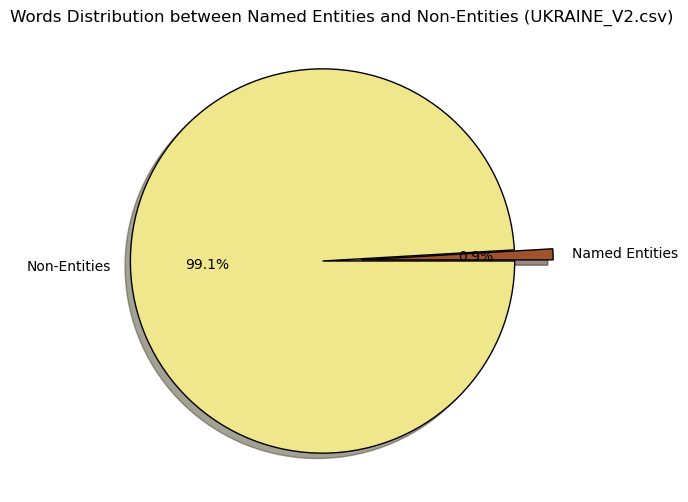

In [27]:
labels = ['Named Entities', 'Non-Entities']
sizes = [total_named_entity_words, total_non_entity_words]
colors = ['sienna','khaki']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', explode=(0.2, 0), shadow=True, wedgeprops={'edgecolor': 'black'})
plt.title('Words Distribution between Named Entities and Non-Entities (UKRAINE_V2.csv)')
plt.axis('equal')
plt.show()

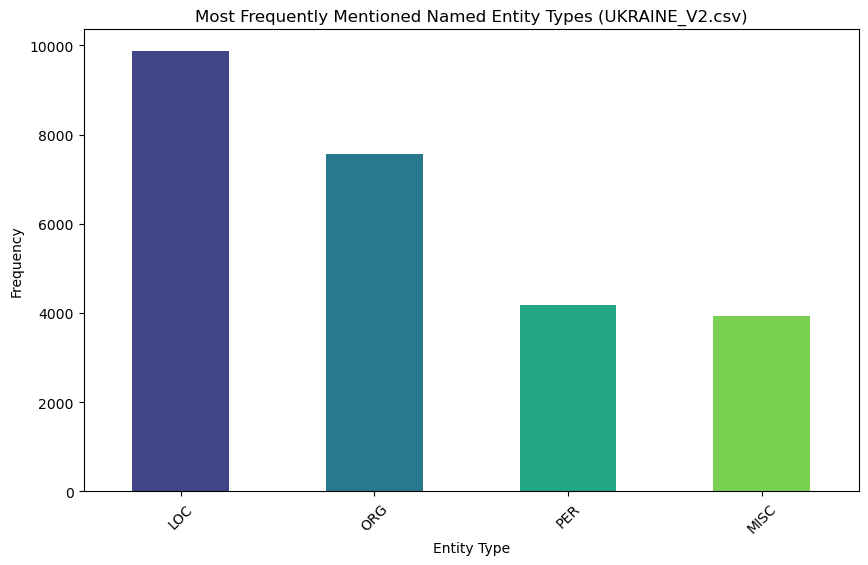

In [28]:
#most frequently mentioned named entity type
def count_entity_types(text):
    entity_types = [entity_type for entity_type, _ in text.values()]
    return entity_types

entity_types = df['NER'].apply(count_entity_types).explode().value_counts()
colors = sns.color_palette('viridis', len(entity_types))

plt.figure(figsize=(10, 6))
entity_types.plot(kind='bar', color=colors)
plt.title('Most Frequently Mentioned Named Entity Types (UKRAINE_V2.csv)')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

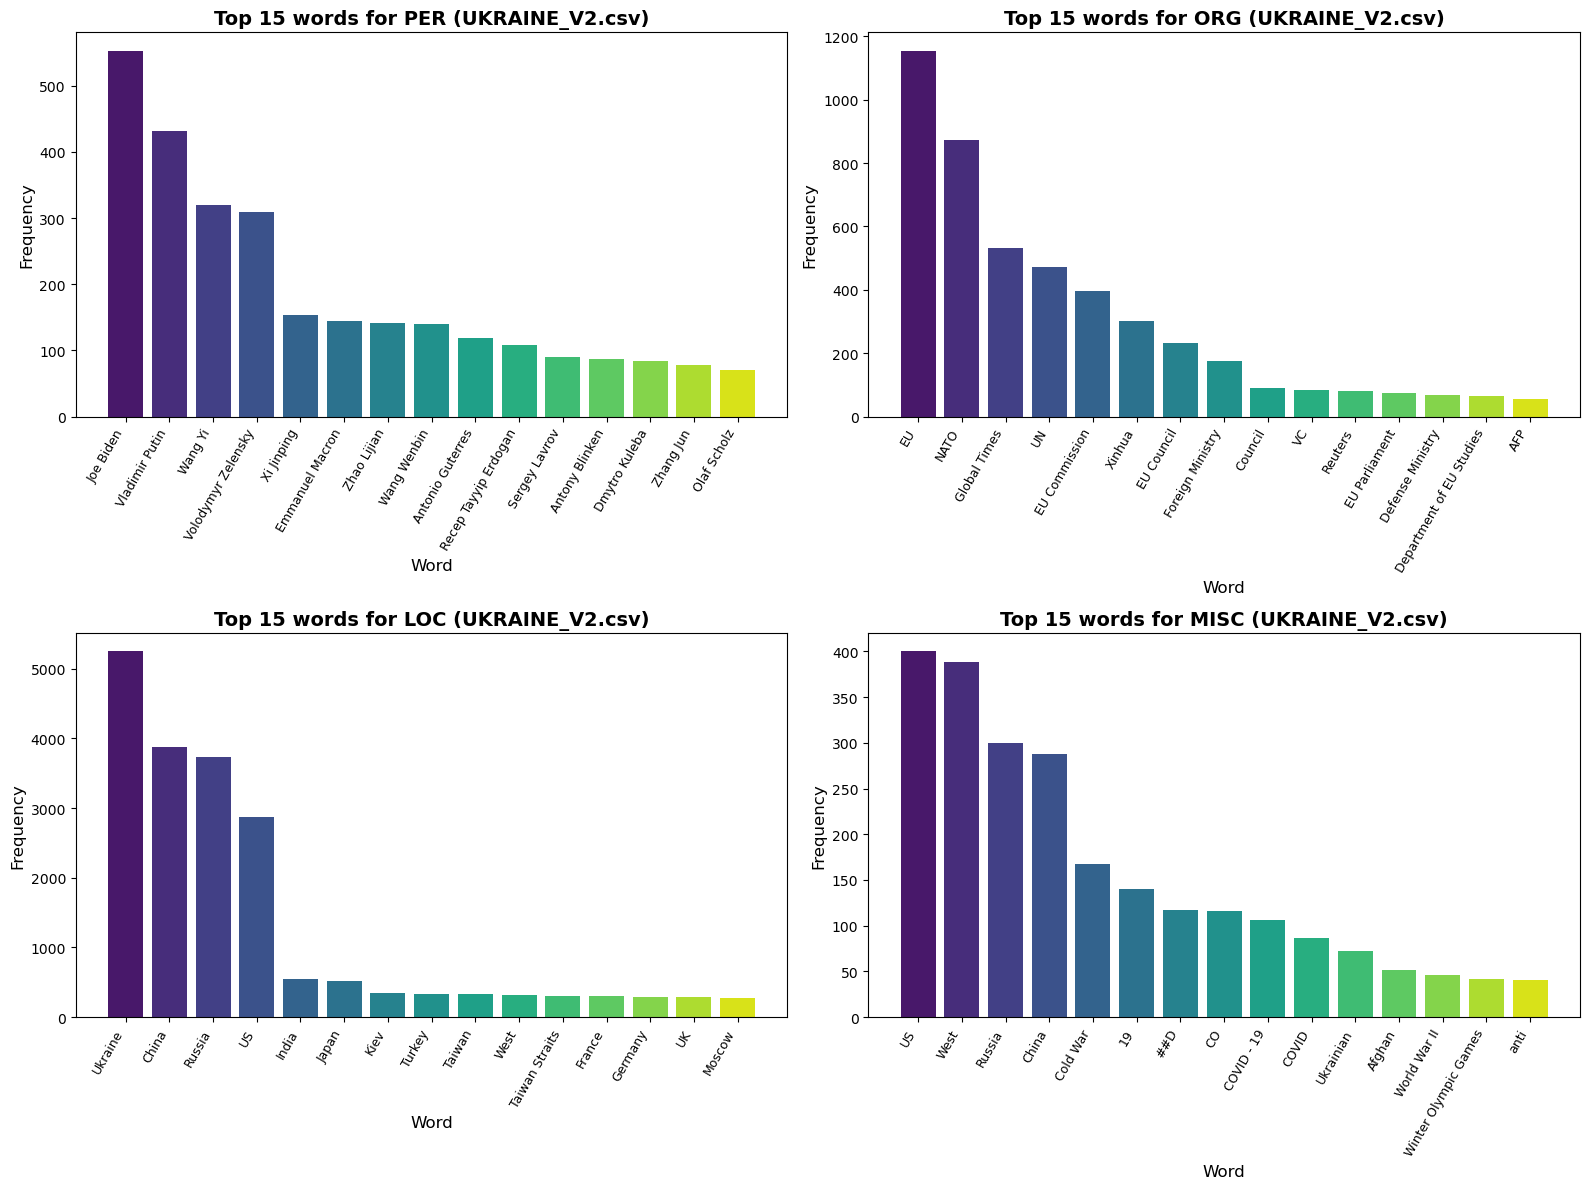

In [31]:
#top 15 words for each entity type
entity_words_dict = defaultdict(Counter)

for ner_dict in df['NER']:
    for word, (entity_type, count) in ner_dict.items():
        entity_words_dict[entity_type][word] += count

colors = sns.color_palette('viridis', 15)
plt.figure(figsize=(16, 12))

for i, (entity_type, words_counter) in enumerate(entity_words_dict.items(), 1):
    top_words = dict(words_counter.most_common(15))
    plt.subplot(2, 2, i)
    plt.bar(top_words.keys(), top_words.values(), color=colors)
    plt.title('Top 15 words for ' + entity_type + ' (UKRAINE_V2.csv)', fontsize=14, fontweight='bold')
    plt.xlabel('Word', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=60, fontsize=9, ha="right")

plt.tight_layout()
plt.show()

In [33]:
#save top 50 words for each entity type in excel file
entity_words_dict = defaultdict(Counter)

for ner_dict in df['NER']:
    for word, (entity_type, count) in ner_dict.items():
        entity_words_dict[entity_type][word] += count

data = {'Entity Type': [], 'Word': [], 'Count': []}

for entity_type, words_counter in entity_words_dict.items():
    top_words = words_counter.most_common(40)
    for word, count in top_words:
        data['Entity Type'].append(entity_type)
        data['Word'].append(word)
        data['Count'].append(count)

df_top_words = pd.DataFrame(data)
excel_file_path = 'Ukraine_v2_TopWords_v2.xlsx'
df_top_words.to_excel(excel_file_path, index=False)

print(f"Top words by entity type have been saved to {excel_file_path}.")

Top words by entity type have been saved to Ukraine_v2_TopWords_v2.xlsx.
